In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

# Continue with regular imports
import os
import sys
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

Force_Redownload = 1
try:
    if Force_Redownload: raise Exception("Force Redownload")
    from CSE203B_Final_Project import engine
    from CSE203B_Final_Project.helper_functions import set_seeds, plot_loss_curves
    from CSE203B_Final_Project.data_prep import prepare_loaders
    from CSE203B_Final_Project.models import SViT, prepare_model
except Exception as E:
    print("[INFO] Downloading Code from GitHub.")
    !rm -rf CSE203B_Final_Project
    !git clone https://github.com/ArmanOmmid/CSE203B_Final_Project
    !mv CSE203B_Final_Project .
finally:
    from CSE203B_Final_Project import engine
    from CSE203B_Final_Project.helper_functions import set_seeds, plot_loss_curves
    from CSE203B_Final_Project.data_prep import prepare_loaders
    from CSE203B_Final_Project.models import SViT, prepare_model

device = "cuda" if torch.cuda.is_available() else "cpu"
device
data_folder = 'datasets'

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116
[INFO] Couldn't find torchinfo... installing it.
[INFO] Downloading Code from GitHub.
Cloning into 'CSE203B_Final_Project'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 39 (delta 17), reused 24 (delta 7), pack-reused 0
Unpacking objects: 100% (39/39), 10.93 KiB | 466.00 KiB/s, done.
mv: 'CSE203B_Final_Project' and './CSE203B_Final_Project' are the same file


In [ ]:
# Create image size (from Table 3 in the ViT paper) ViT Paper used 224 ; # Create transform pipeline manually
IMG_SIZE = 224 
example_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x.repeat(3, 1, 1) if x.size(0)==1 else x)), # Turns to RGB
])           
data_folder = 'datasets'

BATCH_SIZE = 3
NUM_WORKERS = 2
total_images = 2500
test_proportion = 0.2
dataset_name = "FashionMNIST"

train_dataloader, test_dataloader, class_names = prepare_loaders(data_folder, dataset_name, total_images, test_proportion, example_transforms, BATCH_SIZE, NUM_WORKERS)
print(len(train_dataloader.dataset.indices), len(test_dataloader.dataset.indices), len(class_names))

2500 500 10


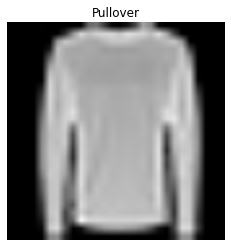

In [ ]:
# Plot image with matplotlib
image_batch, label_batch = next(iter(train_dataloader)) # Get a batch of images
image, label = image_batch[0], label_batch[0] # Get a single image from the batch
image.shape, label # View the batch shapes
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [ ]:
def ViT_Streamline(total_images, test_proportion, dataset_name):

    # Pretrained ViT (Standard)

    vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
    pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

    IMG_SIZE = 224 
    vit_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x.repeat(3, 1, 1) if x.size(0)==1 else x)), # Turns to RGB
    ])

    BATCH_SIZE = 32
    NUM_WORKERS = 2

    train_dataloader, test_dataloader, class_names = prepare_loaders(data_folder, dataset_name, total_images, test_proportion, vit_transforms, BATCH_SIZE, NUM_WORKERS)
    print(len(train_dataloader.dataset.indices), len(test_dataloader.dataset.indices), len(class_names))

    pretrained_vit, model_summary = prepare_model(pretrained_vit, len(class_names))
    # print(model_summary)

    # Train a pretrained ViT feature extractor
    optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()
    set_seeds()

    epochs = 20
    pretrained_vit_results = engine.train(model=pretrained_vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                                        optimizer=optimizer, loss_fn=loss_fn, epochs=epochs, device=device)

    print("")
    # plot_loss_curves(pretrained_vit_results)

    svit_backbone_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

    IMG_SIZE = 224 
    vit_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x.repeat(3, 1, 1) if x.size(0)==1 else x)), # Turns to RGB
    ])

    BATCH_SIZE = 32
    NUM_WORKERS = 2

    train_dataloader, test_dataloader, class_names = prepare_loaders(data_folder, dataset_name, total_images, test_proportion, vit_transforms, BATCH_SIZE, NUM_WORKERS)
    print(len(train_dataloader.dataset.indices), len(test_dataloader.dataset.indices), len(class_names))

    # Pretrained SVM-ViT (Standard)
    svit_backbone = torchvision.models.vit_b_16(weights=svit_backbone_weights)
    svit_backbone, model_summary = prepare_model(svit_backbone)

    svit = SViT(svit_backbone)

    fit_results = svit.fit(train_dataloader)
    score_results = svit.score(test_dataloader)
    print(score_results)

In [ ]:
def SWAG_Streamline(total_images, test_proportion, dataset_name):

    # Pretrained ViT (SWAG)

    vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
    pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)

    swag_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.convert('RGB')), # Turns to RGB
        vit_weights_swag.transforms()
    ])

    BATCH_SIZE = 32
    NUM_WORKERS = 2

    train_dataloader, test_dataloader, class_names = prepare_loaders(data_folder, dataset_name, total_images, test_proportion, swag_transforms, BATCH_SIZE, NUM_WORKERS)
    print(len(train_dataloader.dataset.indices), len(test_dataloader.dataset.indices), len(class_names))

    pretrained_vit_swag, model_summary = prepare_model(pretrained_vit_swag, len(class_names))
    # print(model_summary)

    # Train a pretrained ViT feature extractor with SWAG weights
    optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss() 
    set_seeds()

    epochs = 20
    pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                                        optimizer=optimizer, loss_fn=loss_fn, epochs=epochs, device=device)

    print("")
    # plot_loss_curves(pretrained_vit_swag_results)

    svit_swag_backbone_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights

    swag_transforms = transforms.Compose([
        transforms.Lambda(lambda x: x.convert('RGB')), # Turns to RGB
        svit_swag_backbone_weights.transforms()
    ])

    BATCH_SIZE = 32
    NUM_WORKERS = 2

    train_dataloader, test_dataloader, class_names = prepare_loaders(data_folder, dataset_name, total_images, test_proportion, swag_transforms, BATCH_SIZE, NUM_WORKERS)
    print(len(train_dataloader.dataset.indices), len(test_dataloader.dataset.indices), len(class_names))

    # Pretrained SVM-ViT (SWAG)
    svit_swag_backbone = torchvision.models.vit_b_16(weights=svit_swag_backbone_weights)
    svit_swag_backbone, model_summary = prepare_model(svit_swag_backbone)

    svit_swag = SViT(svit_swag_backbone)

    fit_results = svit_swag.fit(train_dataloader)
    score_results = svit_swag.score(test_dataloader)
    print(score_results)

In [ ]:
dataset = "CIFAR100"
sets = [[(i+1)*10000, 1/((i*2)+2), dataset] for i in range(5)]
sets[4][0] = None
sets

[[10000, 0.5, 'CIFAR100'],
 [20000, 0.25, 'CIFAR100'],
 [30000, 0.16666666666666666, 'CIFAR100'],
 [40000, 0.125, 'CIFAR100'],
 [None, 0.1, 'CIFAR100']]

In [ ]:
ViT_Streamline(*sets[0])

Files already downloaded and verified
Files already downloaded and verified
10000 5000 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5278 | train_acc: 0.8510 | test_loss: 0.3245 | test_acc: 0.8981
Epoch: 2 | train_loss: 0.2935 | train_acc: 0.9053 | test_loss: 0.2941 | test_acc: 0.9029
Epoch: 3 | train_loss: 0.2474 | train_acc: 0.9216 | test_loss: 0.2867 | test_acc: 0.9049
Epoch: 4 | train_loss: 0.2194 | train_acc: 0.9309 | test_loss: 0.2827 | test_acc: 0.9074
Epoch: 5 | train_loss: 0.1999 | train_acc: 0.9365 | test_loss: 0.2813 | test_acc: 0.9062
Epoch: 6 | train_loss: 0.1815 | train_acc: 0.9385 | test_loss: 0.2777 | test_acc: 0.9047
Epoch: 7 | train_loss: 0.1690 | train_acc: 0.9452 | test_loss: 0.2761 | test_acc: 0.9070
Epoch: 8 | train_loss: 0.1577 | train_acc: 0.9498 | test_loss: 0.2738 | test_acc: 0.9100
Epoch: 9 | train_loss: 0.1471 | train_acc: 0.9538 | test_loss: 0.2828 | test_acc: 0.9043
Epoch: 10 | train_loss: 0.1389 | train_acc: 0.9573 | test_loss: 0.2827 | test_acc: 0.9078

Files already downloaded and verified
Files already downloaded and verified
10000 5000 10


100%|██████████| 157/157 [00:18<00:00,  8.70it/s]


0.9146


In [ ]:
SWAG_Streamline(*sets[0])

Files already downloaded and verified
Files already downloaded and verified
10000 5000 100


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2268 | train_acc: 0.6909 | test_loss: 0.7561 | test_acc: 0.7803
Epoch: 2 | train_loss: 0.4832 | train_acc: 0.8570 | test_loss: 0.7037 | test_acc: 0.7990
Epoch: 3 | train_loss: 0.3077 | train_acc: 0.9133 | test_loss: 0.7106 | test_acc: 0.7954
Epoch: 4 | train_loss: 0.2022 | train_acc: 0.9473 | test_loss: 0.7073 | test_acc: 0.7980
Epoch: 5 | train_loss: 0.1416 | train_acc: 0.9686 | test_loss: 0.7354 | test_acc: 0.8006

Files already downloaded and verified
Files already downloaded and verified
10000 5000 100


100%|██████████| 157/157 [00:55<00:00,  2.83it/s]


0.8064


In [ ]:
ViT_Streamline(*sets[1])

Files already downloaded and verified
Files already downloaded and verified
20000 5000 100


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6561 | train_acc: 0.6057 | test_loss: 1.1375 | test_acc: 0.6823
Epoch: 2 | train_loss: 0.9305 | train_acc: 0.7372 | test_loss: 1.0424 | test_acc: 0.7080
Epoch: 3 | train_loss: 0.7625 | train_acc: 0.7832 | test_loss: 0.9886 | test_acc: 0.7253
Epoch: 4 | train_loss: 0.6519 | train_acc: 0.8123 | test_loss: 0.9745 | test_acc: 0.7249
Epoch: 5 | train_loss: 0.5712 | train_acc: 0.8355 | test_loss: 0.9903 | test_acc: 0.7195

Files already downloaded and verified
Files already downloaded and verified
20000 5000 100


100%|██████████| 157/157 [00:18<00:00,  8.68it/s]


0.7224


In [ ]:
SWAG_Streamline(*sets[1])

Files already downloaded and verified
Files already downloaded and verified
20000 5000 100


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9873 | train_acc: 0.7386 | test_loss: 0.7087 | test_acc: 0.7864
Epoch: 2 | train_loss: 0.4883 | train_acc: 0.8545 | test_loss: 0.6785 | test_acc: 0.8049
Epoch: 3 | train_loss: 0.3511 | train_acc: 0.8904 | test_loss: 0.6953 | test_acc: 0.8051
Epoch: 4 | train_loss: 0.2636 | train_acc: 0.9187 | test_loss: 0.7023 | test_acc: 0.8055
Epoch: 5 | train_loss: 0.2003 | train_acc: 0.9391 | test_loss: 0.7492 | test_acc: 0.8053
Epoch: 6 | train_loss: 0.1577 | train_acc: 0.9516 | test_loss: 0.7587 | test_acc: 0.8031
Epoch: 7 | train_loss: 0.1291 | train_acc: 0.9641 | test_loss: 0.7913 | test_acc: 0.8087
Epoch: 8 | train_loss: 0.1042 | train_acc: 0.9715 | test_loss: 0.8309 | test_acc: 0.8016
Epoch: 9 | train_loss: 0.0895 | train_acc: 0.9758 | test_loss: 0.8506 | test_acc: 0.7976

Files already downloaded and verified
Files already downloaded and verified
20000 5000 100


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


0.8312


In [ ]:
ViT_Streamline(*sets[2])

Files already downloaded and verified
Files already downloaded and verified
30000 5000 100


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4732 | train_acc: 0.6312 | test_loss: 1.0750 | test_acc: 0.6988
Epoch: 2 | train_loss: 0.8792 | train_acc: 0.7493 | test_loss: 0.9963 | test_acc: 0.7193
Epoch: 3 | train_loss: 0.7377 | train_acc: 0.7858 | test_loss: 0.9507 | test_acc: 0.7261
Epoch: 4 | train_loss: 0.6460 | train_acc: 0.8097 | test_loss: 0.9657 | test_acc: 0.7247
Epoch: 5 | train_loss: 0.5758 | train_acc: 0.8315 | test_loss: 0.9375 | test_acc: 0.7293
Epoch: 6 | train_loss: 0.5198 | train_acc: 0.8460 | test_loss: 0.9747 | test_acc: 0.7317
Epoch: 7 | train_loss: 0.4735 | train_acc: 0.8606 | test_loss: 0.9618 | test_acc: 0.7311
Epoch: 8 | train_loss: 0.4349 | train_acc: 0.8730 | test_loss: 0.9923 | test_acc: 0.7275

Files already downloaded and verified
Files already downloaded and verified
30000 5000 100


100%|██████████| 157/157 [00:13<00:00, 11.53it/s]


0.734


In [ ]:
SWAG_Streamline(*sets[2])

Files already downloaded and verified
Files already downloaded and verified
30000 5000 100


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8926 | train_acc: 0.7578 | test_loss: 0.6413 | test_acc: 0.8199
Epoch: 2 | train_loss: 0.4974 | train_acc: 0.8499 | test_loss: 0.6646 | test_acc: 0.8179
Epoch: 3 | train_loss: 0.3760 | train_acc: 0.8855 | test_loss: 0.7195 | test_acc: 0.8039
Epoch: 4 | train_loss: 0.3064 | train_acc: 0.9034 | test_loss: 0.7223 | test_acc: 0.8035
Epoch: 5 | train_loss: 0.2492 | train_acc: 0.9212 | test_loss: 0.7826 | test_acc: 0.8021
Epoch: 6 | train_loss: 0.2138 | train_acc: 0.9312 | test_loss: 0.7623 | test_acc: 0.8131
Epoch: 7 | train_loss: 0.1804 | train_acc: 0.9414 | test_loss: 0.7898 | test_acc: 0.8115
Epoch: 8 | train_loss: 0.1539 | train_acc: 0.9504 | test_loss: 0.8316 | test_acc: 0.8063

Files already downloaded and verified
Files already downloaded and verified
30000 5000 100


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


0.8348


In [ ]:
ViT_Streamline(*sets[3])

Files already downloaded and verified
Files already downloaded and verified
40000 5000 100


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3548 | train_acc: 0.6528 | test_loss: 1.0163 | test_acc: 0.7100
Epoch: 2 | train_loss: 0.8526 | train_acc: 0.7544 | test_loss: 0.9785 | test_acc: 0.7217
Epoch: 3 | train_loss: 0.7280 | train_acc: 0.7864 | test_loss: 0.9235 | test_acc: 0.7331
Epoch: 4 | train_loss: 0.6450 | train_acc: 0.8104 | test_loss: 0.9204 | test_acc: 0.7379
Epoch: 5 | train_loss: 0.5812 | train_acc: 0.8286 | test_loss: 0.9238 | test_acc: 0.7377
Epoch: 6 | train_loss: 0.5337 | train_acc: 0.8413 | test_loss: 0.9336 | test_acc: 0.7327
Epoch: 7 | train_loss: 0.4929 | train_acc: 0.8539 | test_loss: 0.9546 | test_acc: 0.7396

Files already downloaded and verified
Files already downloaded and verified
40000 5000 100


100%|██████████| 157/157 [00:13<00:00, 11.55it/s]


0.744


In [ ]:
SWAG_Streamline(*sets[3])

Files already downloaded and verified
Files already downloaded and verified
40000 5000 100


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8411 | train_acc: 0.7678 | test_loss: 0.6715 | test_acc: 0.8077
Epoch: 2 | train_loss: 0.5040 | train_acc: 0.8494 | test_loss: 0.6865 | test_acc: 0.8099
Epoch: 3 | train_loss: 0.3983 | train_acc: 0.8786 | test_loss: 0.6961 | test_acc: 0.8125
Epoch: 4 | train_loss: 0.3378 | train_acc: 0.8939 | test_loss: 0.6916 | test_acc: 0.8225
Epoch: 5 | train_loss: 0.2811 | train_acc: 0.9103 | test_loss: 0.7481 | test_acc: 0.8157
Epoch: 6 | train_loss: 0.2481 | train_acc: 0.9205 | test_loss: 0.7476 | test_acc: 0.8119
Epoch: 7 | train_loss: 0.2180 | train_acc: 0.9291 | test_loss: 0.7754 | test_acc: 0.8141

Files already downloaded and verified
Files already downloaded and verified
40000 5000 100


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


0.8428


In [ ]:
ViT_Streamline(*sets[4])

Files already downloaded and verified
Files already downloaded and verified
50000 5000 100


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2799 | train_acc: 0.6672 | test_loss: 0.9915 | test_acc: 0.7176
Epoch: 2 | train_loss: 0.8342 | train_acc: 0.7592 | test_loss: 0.9151 | test_acc: 0.7369
Epoch: 3 | train_loss: 0.7219 | train_acc: 0.7871 | test_loss: 0.9118 | test_acc: 0.7436
Epoch: 4 | train_loss: 0.6473 | train_acc: 0.8077 | test_loss: 0.9135 | test_acc: 0.7430
Epoch: 5 | train_loss: 0.5891 | train_acc: 0.8236 | test_loss: 0.9339 | test_acc: 0.7412
Epoch: 6 | train_loss: 0.5466 | train_acc: 0.8382 | test_loss: 0.9251 | test_acc: 0.7450

Files already downloaded and verified
Files already downloaded and verified
50000 5000 100


100%|██████████| 157/157 [00:13<00:00, 11.53it/s]


0.7528


In [ ]:
SWAG_Streamline(*sets[4])

Files already downloaded and verified
Files already downloaded and verified
50000 5000 100


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7970 | train_acc: 0.7775 | test_loss: 0.6374 | test_acc: 0.8163
Epoch: 2 | train_loss: 0.5086 | train_acc: 0.8478 | test_loss: 0.6420 | test_acc: 0.8229
Epoch: 3 | train_loss: 0.4159 | train_acc: 0.8726 | test_loss: 0.6706 | test_acc: 0.8205
Epoch: 4 | train_loss: 0.3553 | train_acc: 0.8906 | test_loss: 0.7470 | test_acc: 0.8153
Epoch: 5 | train_loss: 0.3093 | train_acc: 0.9011 | test_loss: 0.7449 | test_acc: 0.8195
Epoch: 6 | train_loss: 0.2696 | train_acc: 0.9127 | test_loss: 0.7835 | test_acc: 0.8123

Files already downloaded and verified
Files already downloaded and verified
50000 5000 100


100%|██████████| 157/157 [00:42<00:00,  3.70it/s]


0.841
